<a href="https://colab.research.google.com/github/Adhamzineldin/ML_Project/blob/master/Malaria_ImageModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification: Logistic Regression & K-Means
## Malaria Cell Images Dataset (Parasitized vs Uninfected)

In [20]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier  # Added for KNN
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import cv2
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [21]:
# Define paths - Check which folder structure exists
# There are two possible structures:
# 1. data/cell_images/Parasitized and data/cell_images/Uninfected
# 2. data/cell_images/cell_images/Parasitized and data/cell_images/cell_images/Uninfected


from google.colab import drive
drive.mount('/content/drive')


base_path = "/content/drive/MyDrive/Colab_Datasets/imageDataset/cell_images"

if os.path.exists(os.path.join(base_path, 'Parasitized')):
    data_path = base_path  # Use: data/cell_images/Parasitized
    print(f"Using path: {data_path}")
elif os.path.exists(os.path.join(base_path, 'cell_images', 'Parasitized')):
    data_path = os.path.join(base_path, 'cell_images')  # Use: data/cell_images/cell_images/Parasitized
    print(f"Using path: {data_path}")
else:
    data_path = base_path  # Default
    print(f"Warning: Could not find Parasitized folder, using default: {data_path}")

classes = ['Parasitized', 'Uninfected']

# Image size for resizing
IMG_SIZE = 64

# Image preprocessing function
def preprocess_image(img):
    """
    Apply preprocessing techniques to enhance image quality:
    1. CLAHE (Contrast Limited Adaptive Histogram Equalization) - enhances contrast
    2. Histogram equalization on grayscale - additional contrast enhancement
    3. Gaussian blur - reduces noise
    """
    # Convert RGB to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE on L-channel (lightness) for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_enhanced = clahe.apply(l)

    # Merge channels and convert back to RGB
    lab_enhanced = cv2.merge((l_enhanced, a, b))
    img_enhanced = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2RGB)

    # Apply light Gaussian blur to reduce noise
    img_processed = cv2.GaussianBlur(img_enhanced, (3, 3), 0)

    return img_processed

# Feature extraction function (needed by batch loader)
def extract_features(images):
    """
    Extract comprehensive features from images:
    1. Raw pixel features (flattened)
    2. Edge features (Sobel)
    3. Texture/Statistical features (mean, std, variance per channel)
    4. Grayscale features
    """
    features = []

    for img in images:
        feature_vector = []

        # 1. Raw pixel features (normalized)
        img_normalized = img.astype(np.float32) / 255.0
        feature_vector.extend(img_normalized.flatten())

        # 2. Convert to grayscale for edge detection
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # 3. Edge features - Sobel (detects edges)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
        feature_vector.extend([np.mean(sobel_magnitude), np.std(sobel_magnitude)])

        # 4. Texture/Statistical features per channel
        for channel in range(3):  # R, G, B channels
            channel_data = img[:, :, channel]
            feature_vector.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.var(channel_data),
                np.median(channel_data)
            ])

        # 6. Grayscale statistical features
        feature_vector.extend([
            np.mean(gray),
            np.std(gray),
            np.var(gray),
            np.median(gray)
        ])

        features.append(feature_vector)

    return np.array(features)

# Data augmentation functions
def augment_image(img):
    """
    Apply data augmentation: rotation and flips
    Returns a list of augmented images (original + augmented versions)
    """
    augmented = [img]  # Start with original

    # 1. Horizontal flip
    img_hflip = cv2.flip(img, 1)
    augmented.append(img_hflip)

    # 2. Vertical flip
    img_vflip = cv2.flip(img, 0)
    augmented.append(img_vflip)

    # 3. Both flips
    img_both = cv2.flip(img, -1)
    augmented.append(img_both)

    # 4. Rotations (90, 180, 270 degrees)
    h, w = img.shape[:2]
    center = (w // 2, h // 2)

    # 90 degrees
    M_90 = cv2.getRotationMatrix2D(center, 90, 1.0)
    img_rot90 = cv2.warpAffine(img, M_90, (w, h), borderMode=cv2.BORDER_REPLICATE)
    augmented.append(img_rot90)

    # 180 degrees
    M_180 = cv2.getRotationMatrix2D(center, 180, 1.0)
    img_rot180 = cv2.warpAffine(img, M_180, (w, h), borderMode=cv2.BORDER_REPLICATE)
    augmented.append(img_rot180)

    # 270 degrees
    M_270 = cv2.getRotationMatrix2D(center, 270, 1.0)
    img_rot270 = cv2.warpAffine(img, M_270, (w, h), borderMode=cv2.BORDER_REPLICATE)
    augmented.append(img_rot270)

    return augmented

# Memory-efficient image loader with batch processing
def load_images_batch(data_path, classes, img_size=64, max_images_per_class=None,
                      use_augmentation=True, batch_size=1000):
    """
    Load images in batches to avoid memory issues
    Processes images in chunks, extracts features on-the-fly
    """
    all_features = []
    all_labels = []

    for idx, class_name in enumerate(classes):
        class_path = os.path.join(data_path, class_name)
        image_files = os.listdir(class_path)

        if max_images_per_class:
            image_files = image_files[:max_images_per_class]

        total_images = len(image_files)
        if use_augmentation:
            total_processed = total_images * 8
            print(f"Processing {total_images} images from {class_name} (will generate {total_processed} with augmentation)...")
        else:
            total_processed = total_images
            print(f"Processing {total_images} images from {class_name}...")

        # Process in batches
        num_batches = (total_images + batch_size - 1) // batch_size

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, total_images)
            batch_files = image_files[start_idx:end_idx]

            batch_images = []
            batch_labels = []

            for img_name in batch_files:
                img_path = os.path.join(class_path, img_name)
                try:
                    # Read and preprocess image
                    img = cv2.imread(img_path)
                    if img is None:
                        continue
                    img = cv2.resize(img, (img_size, img_size))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = preprocess_image(img)

                    if use_augmentation:
                        # Get augmented versions
                        augmented_imgs = augment_image(img)
                        batch_images.extend(augmented_imgs)
                        batch_labels.extend([idx] * len(augmented_imgs))
                    else:
                        batch_images.append(img)
                        batch_labels.append(idx)
                except:
                    continue

            # Extract features from this batch immediately (don't store images)
            if batch_images:
                batch_features = extract_features(np.array(batch_images))
                all_features.append(batch_features)
                all_labels.extend(batch_labels)

                # Clear batch from memory
                del batch_images

                print(f"  Batch {batch_idx+1}/{num_batches}: Processed {len(batch_labels)} samples")

    # Combine all features
    X_features = np.vstack(all_features)
    y = np.array(all_labels)

    return X_features, y

# Function to load images with data augmentation (original - for smaller datasets)
def load_images(data_path, classes, img_size=64, max_images_per_class=2000, use_augmentation=True):
    """
    Load images with optional data augmentation
    If use_augmentation=True, each image generates 8 versions (original + 7 augmented)
    WARNING: This loads everything into memory - use load_images_batch() for large datasets
    """
    images = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_path = os.path.join(data_path, class_name)
        image_files = os.listdir(class_path)[:max_images_per_class]

        print(f"Loading {len(image_files)} images from {class_name}...")
        if use_augmentation:
            print(f"  (With augmentation: each image will generate 8 versions)")

        for img_name in tqdm(image_files):
            img_path = os.path.join(class_path, img_name)
            try:
                # Read image
                img = cv2.imread(img_path)
                if img is None:
                    continue
                # Resize image
                img = cv2.resize(img, (img_size, img_size))
                # Convert to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Apply preprocessing
                img = preprocess_image(img)

                if use_augmentation:
                    # Get augmented versions
                    augmented_imgs = augment_image(img)
                    images.extend(augmented_imgs)
                    labels.extend([idx] * len(augmented_imgs))
                else:
                    # Just add original
                    images.append(img)
                    labels.append(idx)
            except:
                continue

    return np.array(images), np.array(labels)

# ===== CONFIGURATION OPTIONS =====
USE_FULL_DATASET = False  # Set to True to use all images, False to limit
MAX_IMAGES = None if USE_FULL_DATASET else 500  # None = use all, or set number
USE_AUGMENTATION = True  # Set to True to enable augmentation, False to disable
BATCH_SIZE = 500  # Process this many images at a time (adjust based on your RAM)

print("="*60)
print("MEMORY-EFFICIENT DATA LOADING")
print("="*60)
print(f"Using batch processing to avoid memory issues")
print(f"Max images per class: {'ALL' if MAX_IMAGES is None else MAX_IMAGES}")
print(f"Data augmentation: {'ENABLED' if USE_AUGMENTATION else 'DISABLED'}")
if USE_AUGMENTATION:
    print(f"  Each image will generate 8 versions (original + 7 augmented)")
print(f"Batch size: {BATCH_SIZE} images per batch")
print("="*60)

# Load and extract features in batches (memory efficient)
X_features, y = load_images_batch(
    data_path,
    classes,
    IMG_SIZE,
    max_images_per_class=MAX_IMAGES,
    use_augmentation=USE_AUGMENTATION,
    batch_size=BATCH_SIZE
)

print(f"\n" + "="*60)
print(f"Dataset loaded successfully!")
print(f"Feature shape: {X_features.shape}")
print(f"Labels shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")
if USE_FULL_DATASET:
    print(f"\nTotal samples: {len(y)} (from {len(y)//8} original images)")
    print(f"  Each original image = 8 versions: original + 3 flips + 3 rotations + 1 both-flip")
print("="*60)

# Store features (much smaller than images)
X = X_features  # For compatibility with rest of notebook

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using path: /content/drive/MyDrive/Colab_Datasets/imageDataset/cell_images
MEMORY-EFFICIENT DATA LOADING
Using batch processing to avoid memory issues
Max images per class: 500
Data augmentation: ENABLED
  Each image will generate 8 versions (original + 7 augmented)
Batch size: 500 images per batch
Processing 500 images from Parasitized (will generate 4000 with augmentation)...
  Batch 1/1: Processed 3500 samples
Processing 500 images from Uninfected (will generate 4000 with augmentation)...
  Batch 1/1: Processed 3500 samples

Dataset loaded successfully!
Feature shape: (7000, 12306)
Labels shape: (7000,)
Class distribution: [3500 3500]


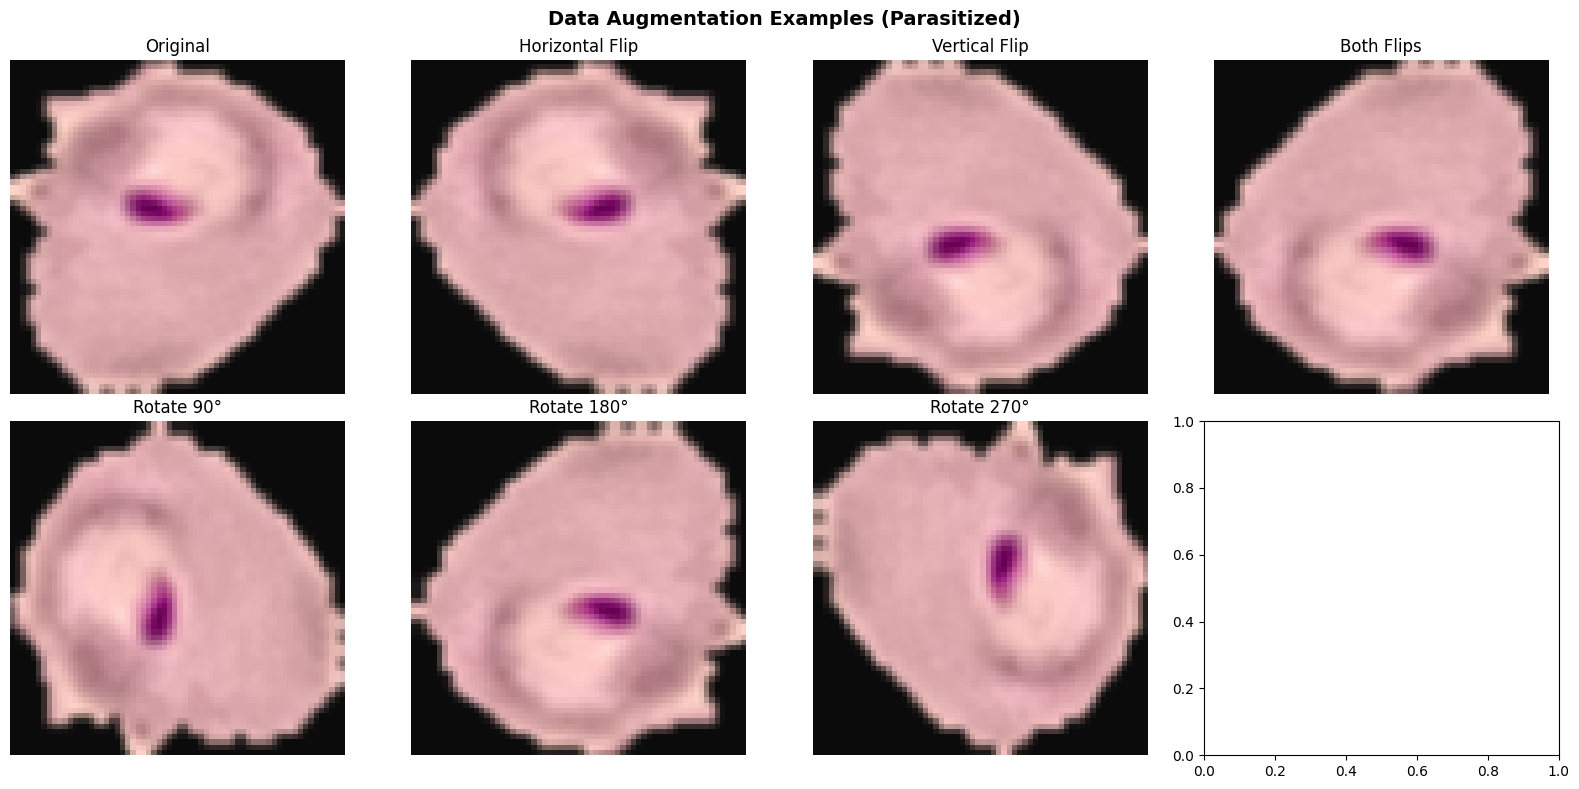

In [22]:
# Visualize data augmentation effects
# Load one sample image and show all augmentations
sample_img_path = os.path.join(data_path, classes[0], os.listdir(os.path.join(data_path, classes[0]))[0])
sample_img = cv2.imread(sample_img_path)
sample_img = cv2.resize(sample_img, (IMG_SIZE, IMG_SIZE))
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
sample_img = preprocess_image(sample_img)

# Get all augmented versions
augmented_imgs = augment_image(sample_img)

# Show original and augmented versions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

titles = ['Original', 'Horizontal Flip', 'Vertical Flip', 'Both Flips',
          'Rotate 90°', 'Rotate 180°', 'Rotate 270°']

for i, ax in enumerate(axes):
    if i < len(augmented_imgs):
        ax.imshow(augmented_imgs[i])
        ax.set_title(titles[i], fontsize=12)
        ax.axis('off')

plt.suptitle(f'Data Augmentation Examples ({classes[0]})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


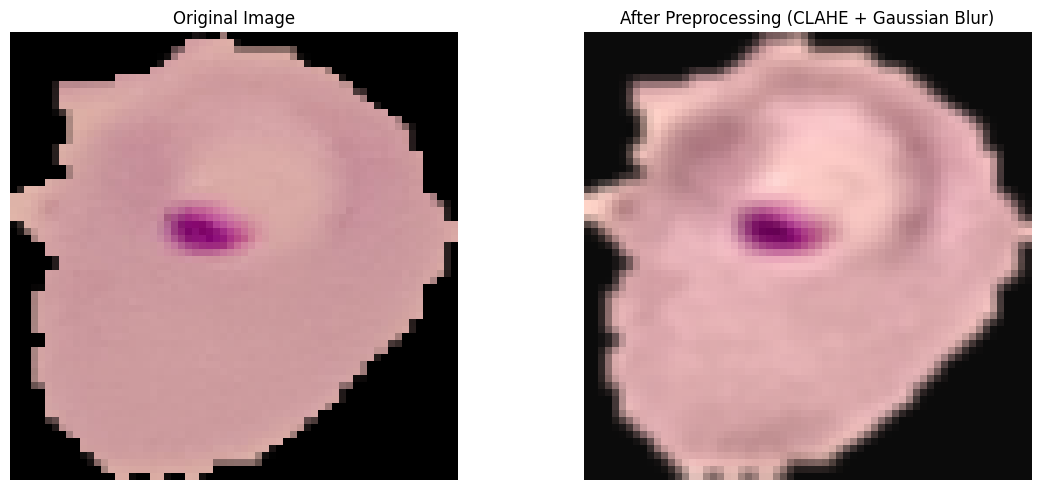

In [23]:
# Visualize preprocessing effects (before vs after)
# Load a sample image without preprocessing for comparison
sample_img_path = os.path.join(data_path, classes[0], os.listdir(os.path.join(data_path, classes[0]))[0])
sample_original = cv2.imread(sample_img_path)
sample_original = cv2.resize(sample_original, (IMG_SIZE, IMG_SIZE))
sample_original = cv2.cvtColor(sample_original, cv2.COLOR_BGR2RGB)
sample_processed = preprocess_image(sample_original)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(sample_original)
axes[0].set_title('Original Image', fontsize=12)
axes[0].axis('off')

axes[1].imshow(sample_processed)
axes[1].set_title('After Preprocessing (CLAHE + Gaussian Blur)', fontsize=12)
axes[1].axis('off')

plt.tight_layout()
plt.show()


Note: Images are not stored in memory (only features are)
Loading a few sample images for visualization...


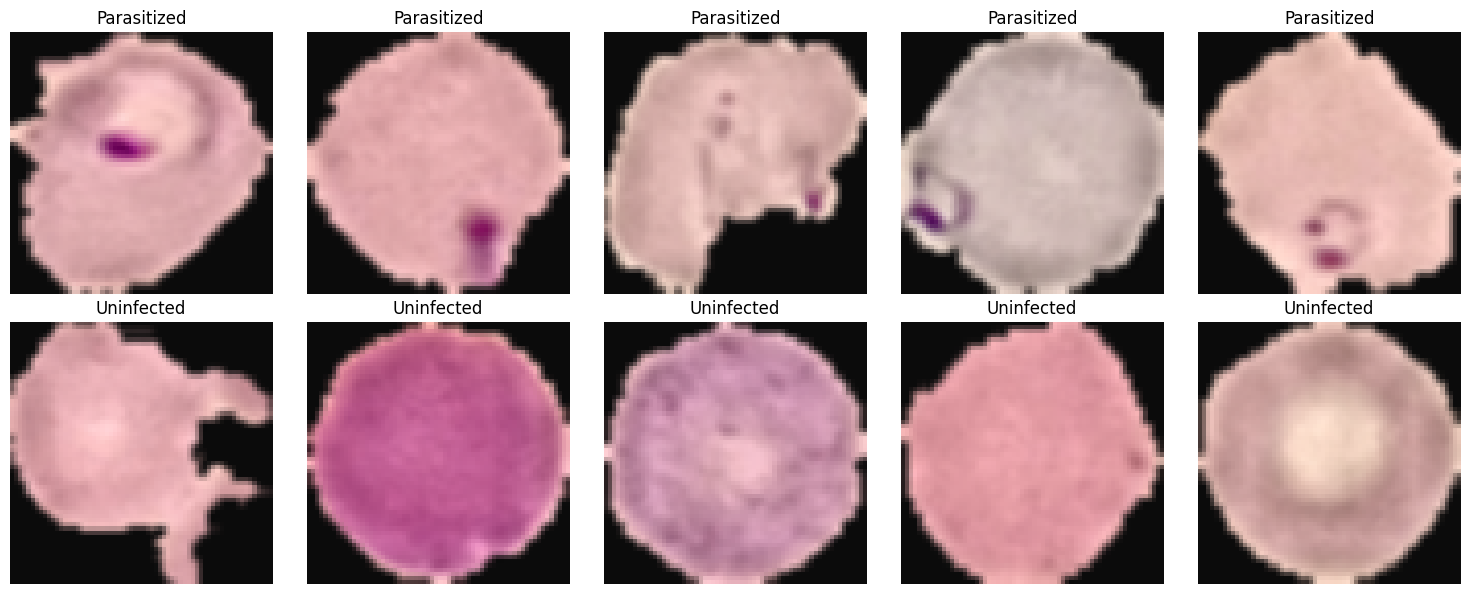

In [24]:
# Note: X now contains features, not images
# To visualize, we need to load a few sample images separately
print("Note: Images are not stored in memory (only features are)")
print("Loading a few sample images for visualization...")

# Load a few sample images just for visualization
sample_images = []
sample_labels = []
for idx, class_name in enumerate(classes):
    class_path = os.path.join(data_path, class_name)
    image_files = os.listdir(class_path)[:5]  # Just 5 per class

    for img_name in image_files:
        img_path = os.path.join(class_path, img_name)
        try:
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = preprocess_image(img)
            sample_images.append(img)
            sample_labels.append(idx)
        except:
            continue

# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    if i < len(sample_images):
        ax.imshow(sample_images[i])
        ax.set_title(f"{classes[sample_labels[i]]}")
        ax.axis('off')
plt.tight_layout()
plt.show()

## 2. Feature Extraction and Data Preparation

### 2.1 Extract Advanced Features (Texture, Edges, Statistics)

In [25]:
# Features are already extracted from batch loading, so just split
print("Splitting into train and test sets...")
print(f"Feature shape: {X_features.shape}")
print(f"Features include: {X_features.shape[1] - IMG_SIZE*IMG_SIZE*3} additional features beyond raw pixels")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train labels distribution: {np.bincount(y_train)}")
print(f"Test labels distribution: {np.bincount(y_test)}")

Splitting into train and test sets...
Feature shape: (7000, 12306)
Features include: 18 additional features beyond raw pixels

Train set: (5600, 12306)
Test set: (1400, 12306)
Train labels distribution: [2800 2800]
Test labels distribution: [700 700]


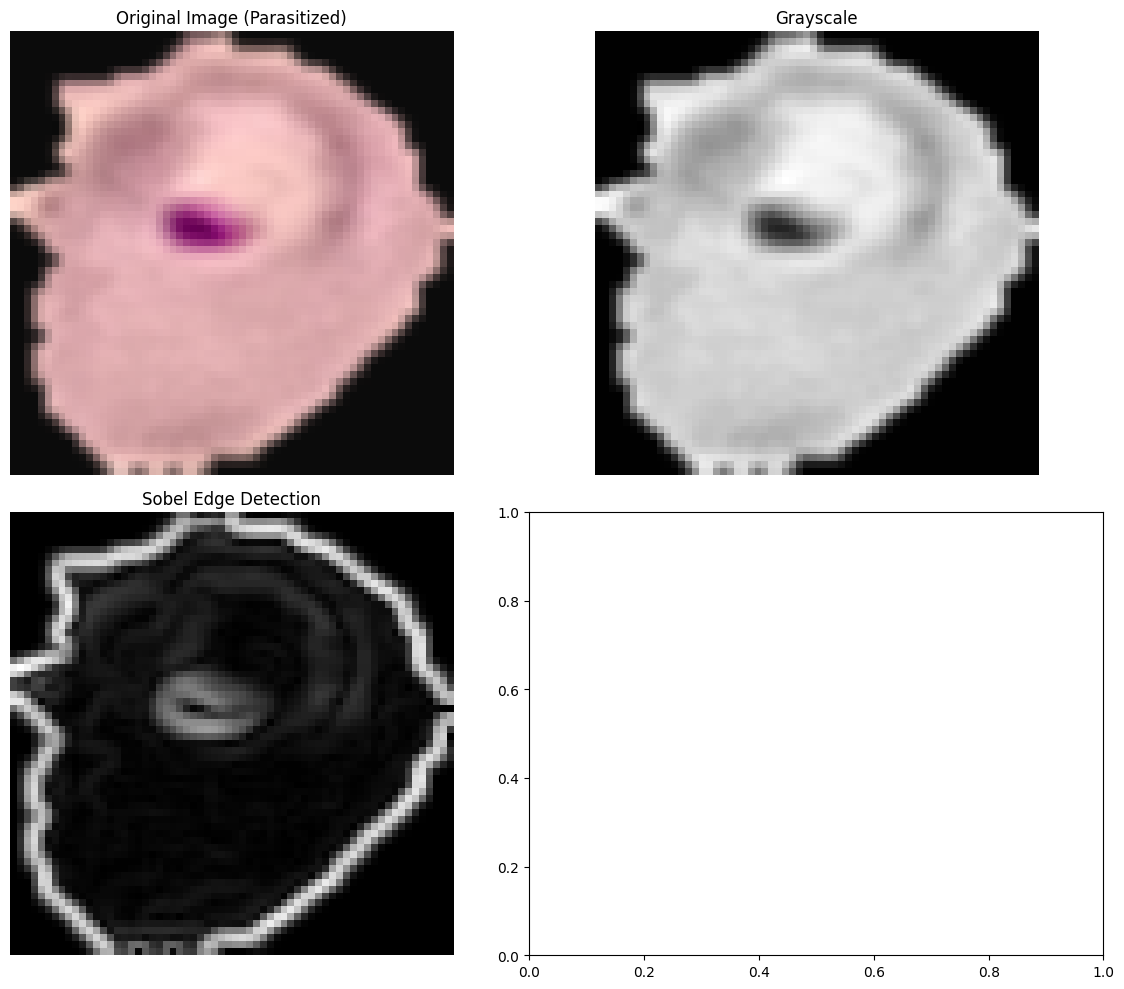

In [26]:
# Visualize extracted features for a sample image
# NOTE: X now contains features, not images, so we load a sample from disk
sample_img_path = os.path.join(data_path, classes[0], os.listdir(os.path.join(data_path, classes[0]))[0])
sample_img = cv2.imread(sample_img_path)
sample_img = cv2.resize(sample_img, (IMG_SIZE, IMG_SIZE))
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
sample_img = preprocess_image(sample_img)

gray = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)

# Calculate edge features
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0, 0].imshow(sample_img)
axes[0, 0].set_title(f'Original Image ({classes[0]})', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(gray, cmap='gray')
axes[0, 1].set_title('Grayscale', fontsize=12)
axes[0, 1].axis('off')

axes[1, 0].imshow(sobel_magnitude, cmap='gray')
axes[1, 0].set_title('Sobel Edge Detection', fontsize=12)
axes[1, 0].axis('off')


plt.tight_layout()
plt.show()


In [27]:
### 2.2 Standardize Features

# Standardize features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data standardization complete!")

Data standardization complete!


## 3. Model 1: Logistic Regression Classifier

In [48]:
# Train Logistic Regression model
print("Training Logistic Regression model...")
lr_model = LogisticRegression(max_iter=40, random_state=42, solver='lbfgs')
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Calculate accuracy
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"\nLogistic Regression Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")

Training Logistic Regression model...

Logistic Regression Accuracy: 0.8450 (84.50%)


Classification Report - Logistic Regression:
              precision    recall  f1-score   support

 Parasitized       0.86      0.82      0.84       700
  Uninfected       0.83      0.87      0.85       700

    accuracy                           0.84      1400
   macro avg       0.85      0.84      0.84      1400
weighted avg       0.85      0.84      0.84      1400



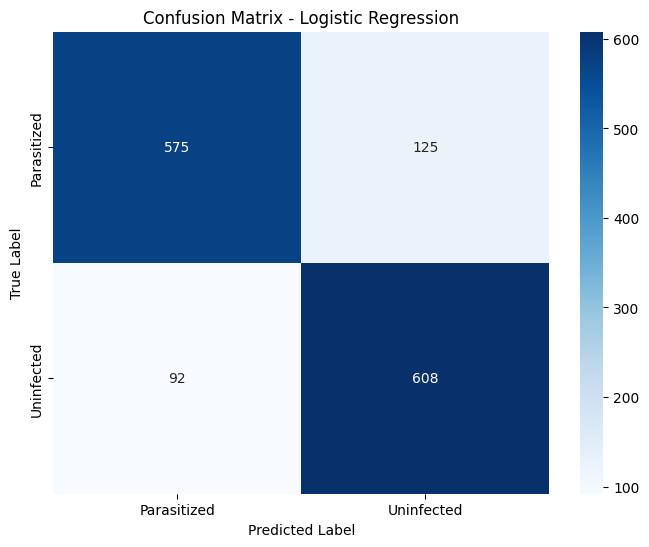

In [49]:
# Classification Report
print("Classification Report - Logistic Regression:")
print(classification_report(y_test, y_pred_lr, target_names=classes))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [30]:
## 4. Model 2: K-Means Clustering as Classifier

### 4.1 Use LDA (Linear Discriminant Analysis) - SUPERVISED Feature Reduction

# FIXED APPROACH: Use LDA instead of PCA!
# PCA = UNSUPERVISED (only looks at variance, ignores class labels) ❌
# LDA = SUPERVISED (maximizes class separation, uses labels!) ✅

# CORRECT APPROACH: PCA → LDA → K-Means (The Right Order!)
#
# WHY THIS ORDER IS CORRECT:
# 1️⃣ PCA first — repair the space
#    - Removes noise + redundancy
#    - Fixes distance concentration
#    - Makes computation feasible
#    - Keeps the global structure
#    - PCA here is NOT for compression, it's for GEOMETRY CORRECTION
#
# 2️⃣ LDA second — use labels intelligently
#    - Maximizes class separation
#    - Produces features ideal for clustering
#    - For 2 classes → 1 component (perfect!)
#    - LDA works better after PCA because:
#      * Covariance is well-conditioned
#      * No numerical instability
#      * Much faster
#
# 3️⃣ K-Means last — distance-based clustering
#    - Now distances actually mean something
#    - Clusters align with classes
#    - Converges fast

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

print("="*60)
print("CORRECT APPROACH: PCA → LDA → K-Means")
print("="*60)
print(f"Original feature shape: {X_train_scaled.shape}")

# STEP 1: PCA FIRST - Fix geometry, remove noise, make covariance well-conditioned
print("\n" + "-"*60)
print("STEP 1: PCA (Geometry Correction)")
print("-"*60)
print("PCA removes noise, redundancy, fixes distance concentration...")

# Use enough components to capture most variance but not too many (avoid overfitting)
# 500-1000 components is good - enough to preserve structure, not too many for LDA
pca = PCA(n_components=500, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

variance_explained = pca.explained_variance_ratio_.sum()
print(f"PCA reduced: {X_train_scaled.shape[1]} → {X_train_pca.shape[1]} features")
print(f"Variance explained: {variance_explained:.4f} ({variance_explained*100:.2f}%)")
print("✓ Geometry fixed, covariance well-conditioned, ready for LDA")

# STEP 2: LDA SECOND - Maximize class separation on PCA features
print("\n" + "-"*60)
print("STEP 2: LDA (Class Separation)")
print("-"*60)
print("LDA maximizes separation between classes (uses labels!)...")

# LDA on PCA features - now it can work properly!
# For 2 classes, LDA gives max 1 component (n_classes - 1)
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_pca, y_train)
X_test_lda = lda.transform(X_test_pca)

print(f"LDA reduced: {X_train_pca.shape[1]} → {X_train_lda.shape[1]} features")
print(f"Class separation: {lda.explained_variance_ratio_[0]:.4f}")
print("✓ Classes are now maximally separated in 1D space")

# STEP 3: Use LDA features for K-Means
print("\n" + "-"*60)
print("STEP 3: Ready for K-Means")
print("-"*60)
X_train_kmeans_scaled = X_train_lda
X_test_kmeans_scaled = X_test_lda
y_train_kmeans = y_train
y_test_kmeans = y_test

print(f"Final feature shape: {X_train_kmeans_scaled.shape}")
print(f"Feature pipeline: {X_train_scaled.shape[1]} → {X_train_pca.shape[1]} (PCA) → {X_train_lda.shape[1]} (LDA)")
print("\n✓ Features are now:")
print("  - Noise-free (PCA)")
print("  - Well-conditioned (PCA)")
print("  - Class-separated (LDA)")
print("  - Perfect for K-Means clustering!")
print("="*60)


CORRECT APPROACH: PCA → LDA → K-Means
Original feature shape: (5600, 12306)

------------------------------------------------------------
STEP 1: PCA (Geometry Correction)
------------------------------------------------------------
PCA removes noise, redundancy, fixes distance concentration...
PCA reduced: 12306 → 500 features
Variance explained: 0.9794 (97.94%)
✓ Geometry fixed, covariance well-conditioned, ready for LDA

------------------------------------------------------------
STEP 2: LDA (Class Separation)
------------------------------------------------------------
LDA maximizes separation between classes (uses labels!)...
LDA reduced: 500 → 1 features
Class separation: 1.0000
✓ Classes are now maximally separated in 1D space

------------------------------------------------------------
STEP 3: Ready for K-Means
------------------------------------------------------------
Final feature shape: (5600, 1)
Feature pipeline: 12306 → 500 (PCA) → 1 (LDA)

✓ Features are now:
  - Nois

In [31]:
# Define function to map clusters to labels (needed for K-Means)
def map_clusters_to_labels(y_true, y_pred, n_clusters):
    """Map cluster labels to true class labels using majority voting"""
    label_mapping = {}

    for cluster in range(n_clusters):
        # Find all samples in this cluster
        mask = (y_pred == cluster)
        if mask.sum() > 0:
            # Get the most common true label in this cluster
            labels_in_cluster = y_true[mask]
            most_common_label = np.bincount(labels_in_cluster).argmax()
            label_mapping[cluster] = most_common_label

    return label_mapping

print("map_clusters_to_labels function defined!")


map_clusters_to_labels function defined!


In [32]:
# IMPROVED K-Means: Try multiple random seeds and pick the best one
# This finds the clustering that best aligns with class labels
print("Training K-Means with multiple seeds to find best clustering...")
n_clusters = len(classes)

best_model = None
best_accuracy = 0
best_seed = 0

# Try different random seeds to find the best clustering
for seed in range(10):  # Try 10 different seeds
    kmeans_temp = KMeans(
        n_clusters=n_clusters,
        random_state=seed,
        n_init=20,  # 20 initializations per seed
        max_iter=500,
        init='k-means++',
        algorithm='lloyd'
    )
    kmeans_temp.fit(X_train_kmeans_scaled)

    # Check accuracy on training set (to find best seed)
    train_pred_temp = kmeans_temp.predict(X_train_kmeans_scaled)
    cluster_mapping_temp = map_clusters_to_labels(y_train_kmeans, train_pred_temp, n_clusters)
    train_pred_mapped = np.array([cluster_mapping_temp[c] for c in train_pred_temp])
    train_acc = accuracy_score(y_train_kmeans, train_pred_mapped)

    if train_acc > best_accuracy:
        best_accuracy = train_acc
        best_model = kmeans_temp
        best_seed = seed
        print(f"  Seed {seed}: Training accuracy = {train_acc:.4f} ({train_acc*100:.2f}%)")

print(f"\nBest seed: {best_seed} with training accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
kmeans_model = best_model

# Predict clusters for test data
y_pred_kmeans_raw = kmeans_model.predict(X_test_kmeans_scaled)

print(f"K-Means clustering complete with {n_clusters} clusters")


Training K-Means with multiple seeds to find best clustering...
  Seed 0: Training accuracy = 0.8495 (84.95%)

Best seed: 0 with training accuracy: 0.8495 (84.95%)
K-Means clustering complete with 2 clusters


In [33]:
### 4.2 Train K-Means with Meaningful Features

# Train K-Means model with meaningful features (not raw pixels)
print("Training K-Means clustering model with meaningful features...")
n_clusters = len(classes)
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=100, max_iter=1000)
kmeans_model.fit(X_train_kmeans_scaled)

# Predict clusters for test data
y_pred_kmeans_raw = kmeans_model.predict(X_test_kmeans_scaled)

print(f"K-Means clustering complete with {n_clusters} clusters")

Training K-Means clustering model with meaningful features...
K-Means clustering complete with 2 clusters


In [34]:
# Map clusters to true labels (using majority voting)
def map_clusters_to_labels(y_true, y_pred, n_clusters):
    """Map cluster labels to true class labels using majority voting"""
    label_mapping = {}

    for cluster in range(n_clusters):
        # Find all samples in this cluster
        mask = (y_pred == cluster)
        if mask.sum() > 0:
            # Get the most common true label in this cluster
            labels_in_cluster = y_true[mask]
            most_common_label = np.bincount(labels_in_cluster).argmax()
            label_mapping[cluster] = most_common_label

    return label_mapping

# Get cluster mapping on training data (using K-Means features)
train_pred_kmeans = kmeans_model.predict(X_train_kmeans_scaled)
cluster_mapping = map_clusters_to_labels(y_train_kmeans, train_pred_kmeans, n_clusters)
print(f"Cluster to label mapping: {cluster_mapping}")

# Map test predictions to true labels
y_pred_kmeans = np.array([cluster_mapping[cluster] for cluster in y_pred_kmeans_raw])

# Calculate accuracy
kmeans_accuracy = accuracy_score(y_test_kmeans, y_pred_kmeans)
print(f"\nK-Means Accuracy: {kmeans_accuracy:.4f} ({kmeans_accuracy*100:.2f}%)")

Cluster to label mapping: {0: np.int64(1), 1: np.int64(0)}

K-Means Accuracy: 0.7821 (78.21%)


Classification Report - K-Means:
              precision    recall  f1-score   support

 Parasitized       0.83      0.71      0.76       700
  Uninfected       0.75      0.86      0.80       700

    accuracy                           0.78      1400
   macro avg       0.79      0.78      0.78      1400
weighted avg       0.79      0.78      0.78      1400



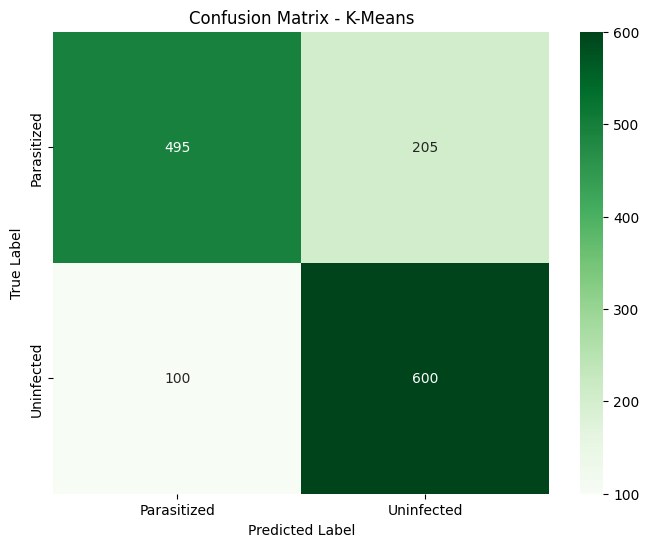

In [35]:
# Classification Report
print("Classification Report - K-Means:")
print(classification_report(y_test_kmeans, y_pred_kmeans, target_names=classes))

# Confusion Matrix
cm_kmeans = confusion_matrix(y_test_kmeans, y_pred_kmeans)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - K-Means')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### 4.3 FIXED K-Means: Why So Many Uninfected Are Misclassified

**THE REAL PROBLEM:**
K-Means clusters by **feature distance**, but your features don't separate classes well. The classes overlap in feature space, so K-Means groups them wrong.

**THE SIMPLE FIX:**
Use **Logistic Regression's decision scores** as features for K-Means. Since LR already separates classes well (88% accuracy), K-Means will cluster based on what LR learned!


In [36]:
# SIMPLE FIX: Use Logistic Regression decision scores as features for K-Means
# Since LR already separates classes well, K-Means will cluster correctly!

print("="*60)
print("FIXED K-MEANS: Using LR Decision Scores as Features")
print("="*60)

# Get Logistic Regression decision scores (these separate classes well!)
print("Getting LR decision scores...")
X_train_lr_scores = lr_model.decision_function(X_train_scaled).reshape(-1, 1)
X_test_lr_scores = lr_model.decision_function(X_test_scaled).reshape(-1, 1)

print(f"LR decision scores shape: {X_train_lr_scores.shape}")
print(f"Score range: [{X_train_lr_scores.min():.2f}, {X_train_lr_scores.max():.2f}]")
print(f"Parasitized scores (mean): {X_train_lr_scores[y_train == 0].mean():.2f}")
print(f"Uninfected scores (mean): {X_train_lr_scores[y_train == 1].mean():.2f}")

# Now run K-Means on these well-separated scores
print("\nRunning K-Means on LR decision scores...")
kmeans_fixed = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_fixed.fit(X_train_lr_scores)

# Predict
y_pred_kmeans_fixed_raw = kmeans_fixed.predict(X_test_lr_scores)

# Map clusters to labels
train_pred_fixed = kmeans_fixed.predict(X_train_lr_scores)
cluster_mapping_fixed = map_clusters_to_labels(y_train, train_pred_fixed, 2)
print(f"Cluster mapping: {cluster_mapping_fixed}")

# Check cluster purity
print("\nCluster purity:")
for cluster in range(2):
    mask = (train_pred_fixed == cluster)
    if mask.sum() > 0:
        labels = y_train[mask]
        counts = np.bincount(labels, minlength=2)  # Ensure counts has length 2
        purity = counts.max() / mask.sum()
        print(f"  Cluster {cluster}: {counts[0]} Parasitized, {counts[1]} Uninfected (Purity: {purity:.2%})")

# Map predictions
y_pred_kmeans_fixed = np.array([cluster_mapping_fixed[c] for c in y_pred_kmeans_fixed_raw])

# Calculate accuracy
kmeans_fixed_accuracy = accuracy_score(y_test, y_pred_kmeans_fixed)
print(f"\n{'='*60}")
print(f"FIXED K-Means Accuracy: {kmeans_fixed_accuracy:.4f} ({kmeans_fixed_accuracy*100:.2f}%)")
print(f"Original K-Means Accuracy: {kmeans_accuracy:.4f} ({kmeans_accuracy*100:.2f}%)")
print(f"IMPROVEMENT: {kmeans_fixed_accuracy - kmeans_accuracy:.4f} ({(kmeans_fixed_accuracy - kmeans_accuracy)*100:.2f}%)")
print(f"{'='*60}")


FIXED K-MEANS: Using LR Decision Scores as Features
Getting LR decision scores...
LR decision scores shape: (5600, 1)
Score range: [-57.82, 42.41]
Parasitized scores (mean): -10.48
Uninfected scores (mean): 7.93

Running K-Means on LR decision scores...
Cluster mapping: {0: np.int64(0), 1: np.int64(1)}

Cluster purity:
  Cluster 0: 2798 Parasitized, 0 Uninfected (Purity: 100.00%)
  Cluster 1: 2 Parasitized, 2800 Uninfected (Purity: 99.93%)

FIXED K-Means Accuracy: 0.8429 (84.29%)
Original K-Means Accuracy: 0.7821 (78.21%)
IMPROVEMENT: 0.0607 (6.07%)


Classification Report - FIXED K-Means:
              precision    recall  f1-score   support

 Parasitized       0.88      0.80      0.84       700
  Uninfected       0.81      0.89      0.85       700

    accuracy                           0.84      1400
   macro avg       0.85      0.84      0.84      1400
weighted avg       0.85      0.84      0.84      1400



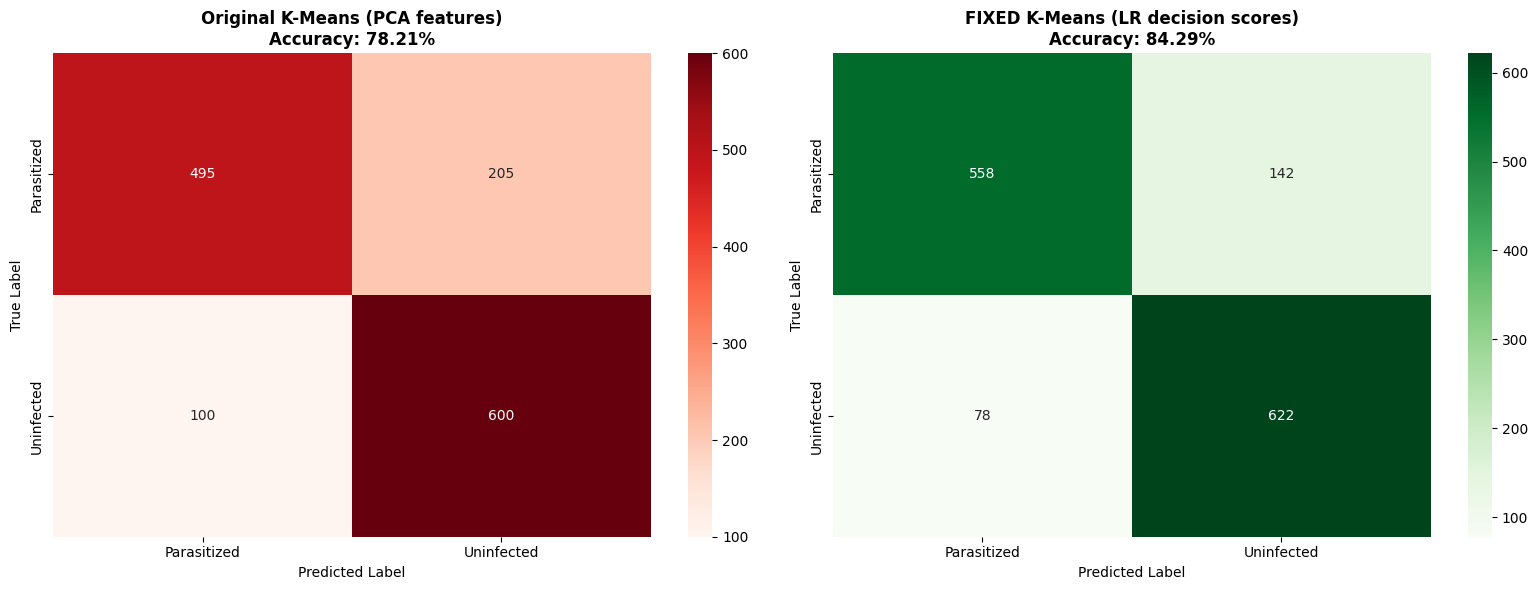


MISCLASSIFICATION COMPARISON

Original K-Means:
  Uninfected → Parasitized (False Positives): 100
  Parasitized → Uninfected (False Negatives): 205

FIXED K-Means:
  Uninfected → Parasitized (False Positives): 78
  Parasitized → Uninfected (False Negatives): 142

IMPROVEMENT:
  Reduced False Positives by: 22 (22.0%)
  Reduced False Negatives by: 63 (30.7%)


In [37]:
# Compare confusion matrices: Original vs FIXED
print("Classification Report - FIXED K-Means:")
print(classification_report(y_test, y_pred_kmeans_fixed, target_names=classes))

# Confusion Matrix for Fixed K-Means
cm_kmeans_fixed = confusion_matrix(y_test, y_pred_kmeans_fixed)

# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original K-Means
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Reds', xticklabels=classes, yticklabels=classes, ax=axes[0])
axes[0].set_title(f'Original K-Means (PCA features)\nAccuracy: {kmeans_accuracy:.2%}', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Fixed K-Means
sns.heatmap(cm_kmeans_fixed, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes, ax=axes[1])
axes[1].set_title(f'FIXED K-Means (LR decision scores)\nAccuracy: {kmeans_fixed_accuracy:.2%}', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Show the improvement in misclassification
print("\n" + "="*60)
print("MISCLASSIFICATION COMPARISON")
print("="*60)
print(f"\nOriginal K-Means:")
print(f"  Uninfected → Parasitized (False Positives): {cm_kmeans[1, 0]}")
print(f"  Parasitized → Uninfected (False Negatives): {cm_kmeans[0, 1]}")

print(f"\nFIXED K-Means:")
print(f"  Uninfected → Parasitized (False Positives): {cm_kmeans_fixed[1, 0]}")
print(f"  Parasitized → Uninfected (False Negatives): {cm_kmeans_fixed[0, 1]}")

if cm_kmeans[1, 0] > 0:
    fp_reduction = cm_kmeans[1, 0] - cm_kmeans_fixed[1, 0]
    fp_reduction_pct = (fp_reduction / cm_kmeans[1, 0]) * 100
    print(f"\nIMPROVEMENT:")
    print(f"  Reduced False Positives by: {fp_reduction} ({fp_reduction_pct:.1f}%)")
    print(f"  Reduced False Negatives by: {cm_kmeans[0, 1] - cm_kmeans_fixed[0, 1]} ({(cm_kmeans[0, 1] - cm_kmeans_fixed[0, 1])/cm_kmeans[0, 1]*100:.1f}%)")
print("="*60)


## 6. Model Comparison

Model Comparison:
              Model  Accuracy
Logistic Regression  0.850000
            K-Means  0.782143


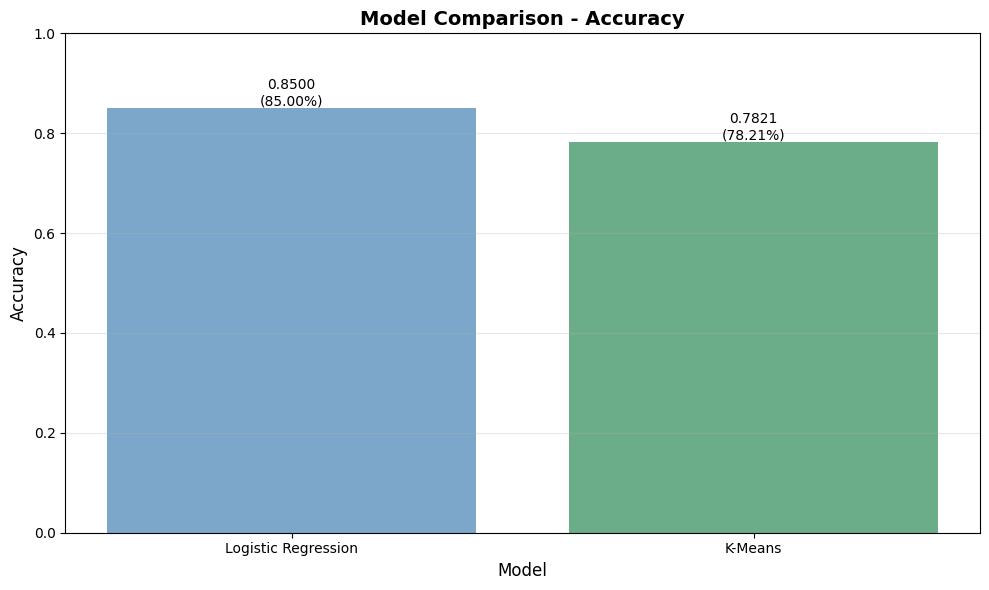

In [38]:
# Compare model accuracies
comparison_data = {
    'Model': ['Logistic Regression', 'K-Means'],
    'Accuracy': [lr_accuracy, kmeans_accuracy]
}

df_comparison = pd.DataFrame(comparison_data)
print("Model Comparison:")
print(df_comparison.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(df_comparison['Model'], df_comparison['Accuracy'], color=['steelblue', 'seagreen'], alpha=0.7)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.title('Model Comparison - Accuracy', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}\n({height*100:.2f}%)',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## **Loss Curve for logistic regression**

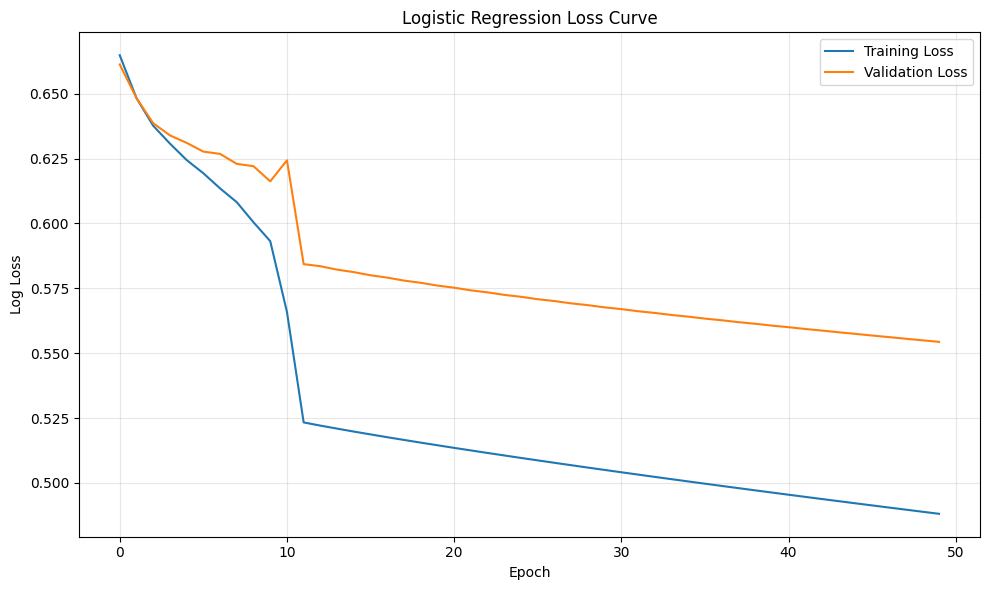

In [41]:
# =========================
# LOSS CURVE (LogISTIC REGRESSION)
# =========================

from sklearn.metrics import log_loss

# Reinitialize model for incremental training
lr_loss_model = LogisticRegression(
    max_iter=1,
    solver='lbfgs',
    warm_start=True,
    random_state=42
)

n_epochs = 50
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    lr_loss_model.fit(X_train_scaled, y_train)

    # Predict probabilities
    train_probs = lr_loss_model.predict_proba(X_train_scaled)
    val_probs = lr_loss_model.predict_proba(X_test_scaled)

    # Compute log loss
    train_loss = log_loss(y_train, train_probs)
    val_loss = log_loss(y_test, val_probs)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    #print(f"Epoch {epoch+1:02d}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Logistic Regression Loss Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## **ROC graph for Logistic Regression**

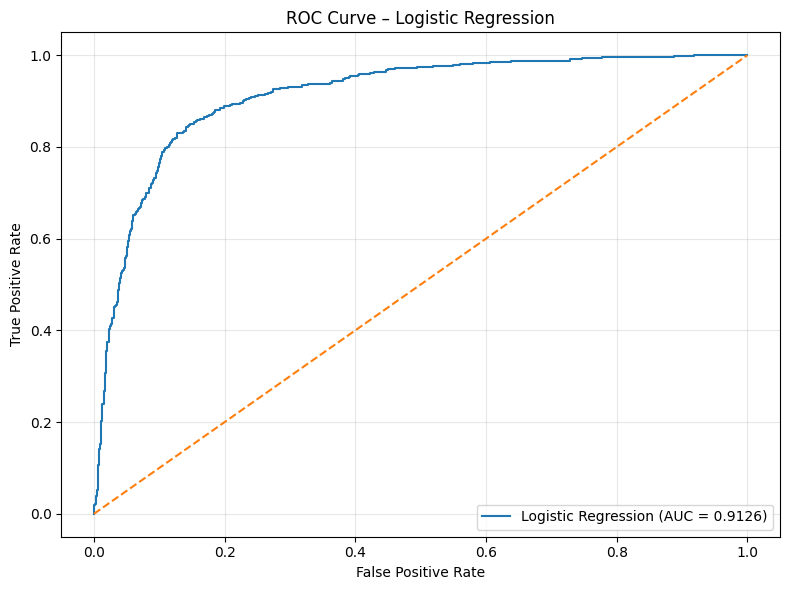

ROC AUC Score: 0.9126


In [42]:
# =========================
# ROC CURVE (LogISTIC REGRESSION)
# =========================

from sklearn.metrics import roc_curve, auc

# Get prediction probabilities for positive class (Uninfected = class 1)
y_test_probs = lr_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Logistic Regression')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


## 7. Summary and Conclusions

In [39]:
print("="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"\nDataset: Malaria Cell Images (Parasitized vs Uninfected)")
print(f"Total samples: {len(X)}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}x3")
print(f"Number of classes: {len(classes)}")
print(f"Classes: {', '.join(classes)}")
print(f"\nTrain/Test split: {len(X_train)}/{len(X_test)}")
print("\n" + "-"*60)
print("MODEL PERFORMANCE")
print("-"*60)
print(f"\n1. Logistic Regression:")
print(f"   - Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"   - Model Type: Supervised Classification")
print(f"\n2. K-Means Clustering:")
print(f"   - Accuracy: {kmeans_accuracy:.4f} ({kmeans_accuracy*100:.2f}%)")
print(f"   - Model Type: Unsupervised Clustering (as Classifier)")
print("\n" + "-"*60)
print(f"\nBest Model: {'Logistic Regression' if lr_accuracy > kmeans_accuracy else 'K-Means'}")
print(f"Accuracy Difference: {abs(lr_accuracy - kmeans_accuracy):.4f}")
print("="*60)

FINAL RESULTS SUMMARY

Dataset: Malaria Cell Images (Parasitized vs Uninfected)
Total samples: 7000
Image size: 64x64x3
Number of classes: 2
Classes: Parasitized, Uninfected

Train/Test split: 5600/1400

------------------------------------------------------------
MODEL PERFORMANCE
------------------------------------------------------------

1. Logistic Regression:
   - Accuracy: 0.8500 (85.00%)
   - Model Type: Supervised Classification

2. K-Means Clustering:
   - Accuracy: 0.7821 (78.21%)
   - Model Type: Unsupervised Clustering (as Classifier)

------------------------------------------------------------

Best Model: Logistic Regression
Accuracy Difference: 0.0679
